In [199]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()

import torch 
import torch.nn as nn 
import torch.optim as optim


from models.learned_qp_solver_bi_cycle_vel_part import MLP_Init, learned_qp_solver
from scipy.io import loadmat
from torch.utils.data import Dataset, DataLoader

In [200]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [201]:
num = 50
t = 0.1


vel_min = 0.0
vel_max = 30.0

acc_min = -6.0
acc_max = 6.0

jerk_min = -6.0
jerk_max = 6.0

In [202]:
v_des =  np.random.uniform(vel_min, vel_max)

num_batch = 500

# vel_samples = np.random.uniform(vel_min, vel_max,  (num_batch, num)    )
vel_samples = np.random.multivariate_normal(v_des*np.ones(num), 10*np.identity(num), (num_batch, ) )


vel_samples = np.clip( vel_samples, vel_min, vel_max  )


# vel_init = np.random.uniform(vel_min, vel_max)*np.ones((num_batch , 1)) 
vel_init = v_des*np.ones((num_batch , 1)) 


inp = np.hstack(( vel_samples, vel_init))

median_ = np.array([14.99712617, 14.98165856, 15.00156322, 15.0315946 , 15.0237649 ,
       14.95290831, 15.02362848, 15.00488991, 14.98256721, 15.02511973,
       15.01874045, 15.01791766, 14.94479826, 15.02234513, 15.00146979,
       15.00260772, 15.04212057, 14.98586476, 14.97039095, 15.01680088,
       15.02091521, 14.99245809, 15.02324861, 14.97728478, 14.98595452,
       15.00038151, 14.96556379, 14.98516695, 15.02776369, 15.03157252,
       15.01656847, 15.04913992, 15.032816  , 15.02177236, 14.95636724,
       15.00040805, 15.00483608, 15.00281992, 14.98058886, 15.04900013,
       15.02005837, 15.00121925, 14.97157685, 15.00349338, 14.92630127,
       14.99345513, 15.02403063, 14.98243826, 14.99892036, 15.03160816,
       15.00260323])
iqr_ = np.array([15.00489034, 14.96979553, 15.02179493, 14.98077341, 14.9401202 ,
       14.94736427, 15.01472935, 14.98427932, 15.02928112, 14.96119056,
       14.98033242, 15.00625851, 14.88887973, 15.00977705, 14.98675345,
       15.01435311, 14.95118661, 15.05150952, 15.03881341, 15.03805316,
       14.99600287, 14.96569228, 14.93651456, 15.06040163, 14.98350009,
       15.02995742, 14.91813083, 15.00162581, 14.98425137, 15.07897904,
       14.94457048, 14.97445598, 14.98252818, 14.99157274, 14.98652712,
       14.99993726, 15.03111512, 15.01579364, 14.96811747, 14.98984632,
       15.02163057, 15.01268755, 15.03481071, 14.99005507, 15.01660515,
       15.03712912, 14.95232336, 15.01972352, 15.03382282, 14.98628055,
       14.99610719])


# median_ = np.median(inp, axis=0)
# q1 = np.percentile(inp, 25, axis=0)
# q3 = np.percentile(inp, 75, axis=0)
# iqr_ = q3 - q1
# # Handle constant features
# iqr_ = np.where(iqr_ == 0, 1, iqr_)


inp_mean = 14.999611530174786 
inp_std = 8.660444587570895

# inp_min = 0.0
# inp_max = 30.0

inp_mean_2, inp_std_2 = inp.mean(), inp.std()

print(inp_mean_2, inp_std_2)

median_ = torch.tensor(median_).float().to(device)
iqr_ = torch.tensor(iqr_).float().to(device)


7.665488570370739 3.102983351648668


In [203]:


mlp_init_inp_dim = np.shape(inp)[1]
mlp_init_hidden_dim = 1024
# mlp_init_out_dim = (2*nvar)**2+2*nvar+2*nvar
mlp_init_out_dim = 2*num+(2*num+2*num+2*(num-1)+2*(num-2))

# mlp_pred = MLP_Pred(mlp_pred_inp_dim, mlp_pred_hidden_dim, mlp_pred_out_dim  )
mlp_init = MLP_Init(mlp_init_inp_dim, mlp_init_hidden_dim, mlp_init_out_dim  )


model = learned_qp_solver(num_batch, num, t, mlp_init, inp_mean, inp_std).to(device)
model.load_state_dict(torch.load('./weights/learned_qp_bi_cycle_vel_part.pth'))


<All keys matched successfully>

[1.4282919  0.5075765  0.3660468  0.27310532 0.21058388]
[0. 0. 0. 0. 0.]


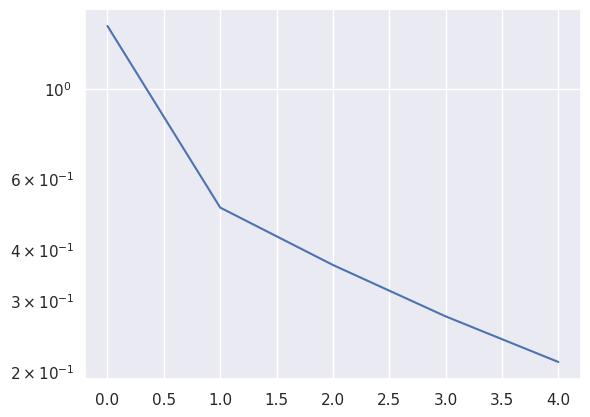

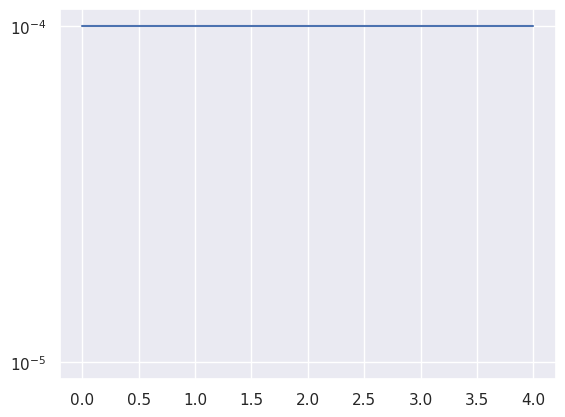

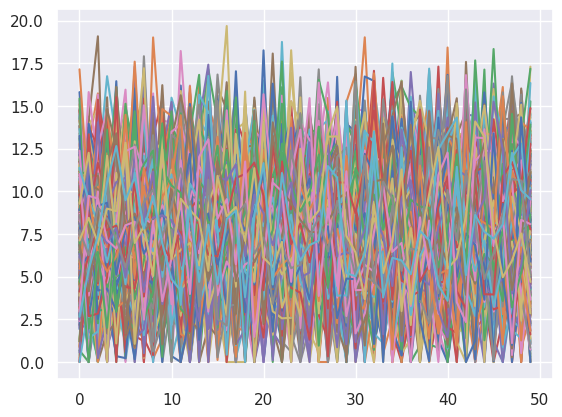

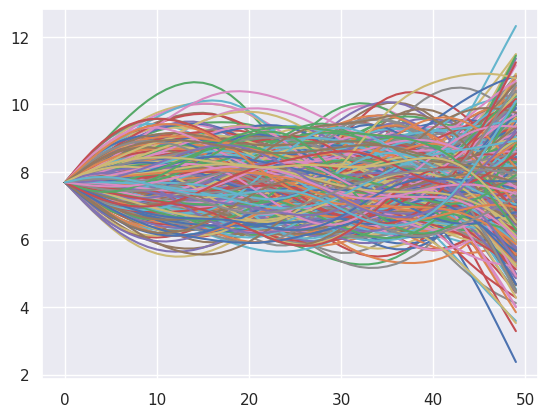

In [204]:
#################3


inp_test = inp
inp_test = torch.tensor(inp_test).float()
inp_test = inp_test.to(device)
# inp_test = torch.vstack([inp_test] * num_batch)
# inp_norm_test = (inp_test - inp_mean) / inp_std
inp_norm_test = (inp_test-median_)/iqr_
# inp_norm_test = (inp_test - inp_min) / (inp_max-inp_min)

# inp_norm_test = inp_test 



vel_init_test = vel_init[0]
vel_init_test = torch.tensor(vel_init_test).float()
vel_init_test = vel_init_test.to(device)



# vel_init_test = torch.vstack([vel_init_test] * num_batch)


vel_samples_test = vel_samples
vel_samples_test = torch.tensor(vel_samples_test).float()
vel_samples_test = vel_samples_test.to(device)
# vel_samples_test = torch.vstack([vel_samples_test] * num_batch)

with torch.no_grad():
    vel_projected, res_primal_stack, res_fixed_point_stack, accumulated_res_primal, accumulated_res_fixed_point = model.decoder_function(inp_norm_test, vel_init_test, vel_samples_test, vel_max, vel_min, acc_max, acc_min, jerk_max, jerk_min)



print(res_fixed_point_stack[:, 0].cpu().detach().numpy())
print(res_primal_stack[:, 0].cpu().detach().numpy())

plt.figure(1)
plt.plot(res_fixed_point_stack[:, 0].cpu().detach().numpy())
plt.yscale('log')


plt.figure(2)
plt.plot(res_primal_stack[:, 0].cpu().detach().numpy()+0.0001)
plt.yscale('log')


plt.figure(3)

plt.plot(vel_samples_test.T.cpu().detach().numpy())

plt.figure(4)
plt.plot(vel_projected.T.cpu().detach().numpy())

plt.show()


